# Feature Based Scheduler run with SOCS and custom scheduler configuration

This example notebook show how to do a slightly more complex 1 day FBS run using SOCS. In this example we use a custom FBS configuration done directly on the notebook.

Before running the notebook make sure you run `manage_db --save-dir $HOME/run_local/output/` on the command line to setup the SOCS database. 

In [1]:
import logging
import healpy as hp
import numpy as np

import lsst.sims.featureScheduler as fs

from lsst.sims.featureScheduler.driver import FeatureSchedulerDriver as Driver

from lsst.sims.ocs.database import SocsDatabase
from lsst.sims.ocs.kernel import Simulator
from lsst.sims.ocs.setup import create_parser
from lsst.sims.ocs.setup import apply_file_config, read_file_config

from lsst.ts.scheduler.kernel import SurveyTopology

In [2]:
logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

This next cell loads default command line arguments. These are needed mainly to setup the simulation database.

In [3]:
parser = create_parser()
args = parser.parse_known_args()[0]
prog_conf = read_file_config()
if prog_conf is not None:
    apply_file_config(prog_conf, args)
print(args.sqlite_save_dir, args.session_id_start, args.sqlite_session_save_dir)

/home/opsim/run_local/output/ None None


Setup socs database to store simulations results, if needed.

In [4]:
db = SocsDatabase(sqlite_save_path=args.sqlite_save_dir,
                  session_id_start=args.session_id_start,
                  sqlite_session_save_path=args.sqlite_session_save_dir)

In [5]:
session_id = db.new_session("FBS test on notebook")

We now define a driver for the simulation. In this case, we already imported the FBS driver as Driver so we simply call it.

In [6]:
driver = Driver()

By default the duration of a simulation is 10 years. Here we will run a single day.

In [7]:
args.frac_duration = 0.003

We now set the SOCS simulator

In [8]:
sim = Simulator(args, db, driver=driver)

Up to this point, the scheduler is still not configured. Let's make a custom configuration. 

In [9]:
survey_topology = SurveyTopology()
survey_topology.num_general_props = 4
survey_topology.general_propos = ["NorthEclipticSpur", "SouthCelestialPole", "WideFastDeep", "GalacticPlane"]
survey_topology.num_seq_props = 1
survey_topology.sequence_propos = ["DeepDrillingCosmology1"]

target_maps = {}
nside = fs.set_default_nside(nside=32)  # Required

target_maps['u'] = fs.generate_goal_map(NES_fraction=0.,
                                        WFD_fraction=0.31, SCP_fraction=0.08,
                                        GP_fraction=0.004,
                                        WFD_upper_edge_fraction=0.0,
                                        nside=nside,
                                        generate_id_map=True)
target_maps['g'] = fs.generate_goal_map(NES_fraction=0.2,
                                        WFD_fraction=0.44, SCP_fraction=0.08,
                                        GP_fraction=0.004,
                                        WFD_upper_edge_fraction=0.0,
                                        nside=nside,
                                        generate_id_map=True)
target_maps['r'] = fs.generate_goal_map(NES_fraction=0.46,
                                        WFD_fraction=1.0, SCP_fraction=0.08,
                                        WFD_upper_edge_fraction=0.0,
                                        GP_fraction=0.004,
                                        nside=nside,
                                        generate_id_map=True)
target_maps['i'] = fs.generate_goal_map(NES_fraction=0.46,
                                        WFD_fraction=1.0, SCP_fraction=0.08,
                                        GP_fraction=0.004,
                                        WFD_upper_edge_fraction=0.0,
                                        nside=nside,
                                        generate_id_map=True)
target_maps['z'] = fs.generate_goal_map(NES_fraction=0.4,
                                        WFD_fraction=0.9, SCP_fraction=0.08,
                                        GP_fraction=0.004,
                                        WFD_upper_edge_fraction=0.0,
                                        nside=nside,
                                        generate_id_map=True)
target_maps['y'] = fs.generate_goal_map(NES_fraction=0.,
                                        WFD_fraction=0.9, SCP_fraction=0.08,
                                        GP_fraction=0.004,
                                        WFD_upper_edge_fraction=0.0,
                                        nside=nside,
                                        generate_id_map=True)

cloud_map = fs.utils.generate_cloud_map(target_maps, filtername='r',
                                        wfd_cloud_max=0.7,
                                        scp_cloud_max=0.7,
                                        gp_cloud_max=0.7,
                                        nes_cloud_max=0.7)

# x1 = 30.
# x0 = 2.
# B = x1 / (x1 - x0)
# A = -B / x1
# width = np.arange(x0, x1, 0.5)
# z_pad = width + 8.
# weight = (A * width + B)
# height = np.zeros_like(width) + 80.

width = (10.,)
z_pad = (18.,)
weight = (1.,)
height = (80.,)

filters = ['u', 'g', 'r', 'i', 'z', 'y']
surveys = []

sb_limit_map = fs.utils.generate_sb_map(target_maps, filters)

filter_prop = {'u': 0.069,
               'g': 0.097,
               'r': 0.222,
               'i': 0.222,
               'z': 0.194,
               'y': 0.194}

for filtername in filters:
    bfs = list()
    # bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.HourAngle_bonus_basis_function(max_hourangle=3.))
    bfs.append(fs.Skybrightness_limit_basis_function(nside=nside,
                                                     filtername=filtername,
                                                     min=sb_limit_map[filtername]['min'],
                                                     max=sb_limit_map[filtername]['max']))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_maps[filtername][0],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside))
    bfs.append(fs.MeridianStripeBasisFunction(nside=nside,width=width,
                                              weight=weight,
                                              height=height,
                                              zenith_pad=z_pad))
    # bfs.append(fs.HADecAltAzPatchBasisFunction(nside=nside,
    #                                            patches=patches[::-1]))
    bfs.append(fs.Aggressive_Slewtime_basis_function(filtername=filtername, nside=nside, order=6., hard_max=20.))
    bfs.append(fs.Goal_Strict_filter_basis_function(filtername=filtername,
                                               time_lag_min=90.,
                                               time_lag_max=150.,
                                               time_lag_boost=180.,
                                               boost_gain=1.0,
                                               unseen_before_lag=True,
                                               proportion=filter_prop[filtername],
                                               aways_available=filtername in 'zy'))
    bfs.append(fs.Avoid_Fast_Revists(filtername=None, gap_min=240., nside=nside))
    bfs.append(fs.Bulk_cloud_basis_function(max_cloud_map=cloud_map, nside=nside))
    bfs.append(fs.Moon_avoidance_basis_function(nside=nside, moon_distance=40.))
    # bfs.append(fs.CableWrap_unwrap_basis_function(nside=nside, activate_tol=70., unwrap_until=315,
    #                                               max_duration=90.))
    # bfs.append(fs.NorthSouth_scan_basis_function(length=70.))

    weights = np.array([2., 0.1, .1, 1., 3., 1.5, 1.0, 1.0, 1.0])
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1,
                                           filtername=filtername, dither=True,
                                           nside=nside,
                                           tag_fields=True,
                                           tag_map=target_maps[filtername][1],
                                           tag_names=target_maps[filtername][2],
                                           ignore_obs='DD'))

# Set up pairs
pairs_bfs = []

pair_map = np.zeros(len(target_maps['z'][0]))
pair_map.fill(hp.UNSEEN)
wfd = np.where(target_maps['z'][1] == 3)
nes = np.where(target_maps['z'][1] == 1)
pair_map[wfd] = 1.
pair_map[nes] = 1.

pairs_bfs.append(fs.Target_map_basis_function(filtername='',
                                              target_map=pair_map,
                                              out_of_bounds_val=hp.UNSEEN, nside=nside))
pairs_bfs.append(fs.MeridianStripeBasisFunction(nside=nside, zenith_pad=(45.,), width=(35.,)))
pairs_bfs.append(fs.Moon_avoidance_basis_function(nside=nside, moon_distance=30.))

# surveys.append(fs.Pairs_survey_scripted(pairs_bfs, [1., 1., 1.], ignore_obs='DD', min_alt=20.))
surveys.append(fs.Pairs_different_filters_scripted(pairs_bfs, [1., 1., 1.], ignore_obs='DD', min_alt=20.,
                                                   filter_goals=filter_prop))
# surveys.append(fs.Pairs_survey_scripted([], [], ignore_obs='DD'))

# Set up the DD
# ELAIS S1
surveys.append(fs.Deep_drilling_survey(9.45, -44., sequence='rgizy',
                                       nvis=[20, 10, 20, 26, 20],
                                       survey_name='DD:ELAISS1', reward_value=100, moon_up=None,
                                       fraction_limit=0.148, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside,
                                       avoid_same_day=True,
                                       filter_goals=filter_prop))
surveys.append(fs.Deep_drilling_survey(9.45, -44., sequence='u',
                                       nvis=[7],
                                       survey_name='DD:u,ELAISS1', reward_value=100, moon_up=False,
                                       fraction_limit=0.0012, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside))

# XMM-LSS
surveys.append(fs.Deep_drilling_survey(35.708333, -4 - 45 / 60., sequence='rgizy',
                                       nvis=[20, 10, 20, 26, 20],
                                       survey_name='DD:XMM-LSS', reward_value=100, moon_up=None,
                                       fraction_limit=0.148, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside,
                                       avoid_same_day=True,
                                       filter_goals=filter_prop))
surveys.append(fs.Deep_drilling_survey(35.708333, -4 - 45 / 60., sequence='u',
                                       nvis=[7],
                                       survey_name='DD:u,XMM-LSS', reward_value=100, moon_up=False,
                                       fraction_limit=0.0012, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside))

# Extended Chandra Deep Field South
# XXX--Note, this one can pass near zenith. Should go back and add better planning on this.
surveys.append(fs.Deep_drilling_survey(53.125, -28. - 6 / 60., sequence='rgizy',
                                       nvis=[20, 10, 20, 26, 20],
                                       survey_name='DD:ECDFS', reward_value=100, moon_up=None,
                                       fraction_limit=0.148, ha_limits=[[0.5, 1.0], [23., 22.5]],
                                       nside=nside,
                                       avoid_same_day=True,
                                       filter_goals=filter_prop))
surveys.append(fs.Deep_drilling_survey(53.125, -28. - 6 / 60., sequence='u',
                                       nvis=[7],
                                       survey_name='DD:u,ECDFS', reward_value=100, moon_up=False,
                                       fraction_limit=0.0012, ha_limits=[[0.5, 1.0], [23., 22.5]],
                                       nside=nside))
# COSMOS
surveys.append(fs.Deep_drilling_survey(150.1, 2. + 10. / 60. + 55 / 3600., sequence='rgizy',
                                       nvis=[20, 10, 20, 26, 20],
                                       survey_name='DD:COSMOS', reward_value=100, moon_up=None,
                                       fraction_limit=0.148, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside,
                                       avoid_same_day=True,
                                       filter_goals=filter_prop))
surveys.append(fs.Deep_drilling_survey(150.1, 2. + 10. / 60. + 55 / 3600., sequence='u',
                                       nvis=[7], ha_limits=([0., .5], [23.5, 24.]),
                                       survey_name='DD:u,COSMOS', reward_value=100, moon_up=False,
                                       fraction_limit=0.0012,
                                       nside=nside))

# Extra DD Field, just to get to 5. Still not closed on this one
surveys.append(fs.Deep_drilling_survey(349.386443, -63.321004, sequence='rgizy',
                                       nvis=[20, 10, 20, 26, 20],
                                       survey_name='DD:290', reward_value=100, moon_up=None,
                                       fraction_limit=0.148, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside,
                                       avoid_same_day=True,
                                       filter_goals=filter_prop))
surveys.append(fs.Deep_drilling_survey(349.386443, -63.321004, sequence='u',
                                       nvis=[7],
                                       survey_name='DD:u,290', reward_value=100, moon_up=False,
                                       fraction_limit=0.0012, ha_limits=([0., 0.5], [23.5, 24.]),
                                       nside=nside,
                                       filter_goals=filter_prop))

scheduler = fs.Core_scheduler(surveys, nside=nside)  # Required

Now we load the configuration to driver. We basically need to two two steps, load `scheduler`, `nside` and `survey_topology`.  

In [10]:
sim.driver.scheduler = scheduler
sim.driver.sky_nside = nside

sim.conf_comm.num_proposals = survey_topology.num_props
sim.conf_comm.survey_topology['general'] = survey_topology.general_propos
sim.conf_comm.survey_topology['sequence'] = survey_topology.sequence_propos

We now initialize the simulator.

In [11]:
sim.initialize()

09-11 19:44 kernel.Simulator INFO     Initializing simulation
09-11 19:44 kernel.Simulator INFO     Simulation Session Id = 2002
09-11 19:44 configuration.ConfigurationCommunicator INFO     Initializing configuration communication
09-11 19:44 kernel.Simulator INFO     Finishing simulation initialization


And we are ready to run the simulation.

In [12]:
sim.run()

09-11 19:44 kernel.Simulator INFO     Starting simulation
09-11 19:44 kernel.Simulator INFO     run: rx scheduler config survey_duration=3650.0
09-11 19:44 kernel.Simulator INFO     run: rx driver config={'ranking': {'coadd_values': 1, 'time_balancing': 1, 'timecost_time_max': 150.0, 'timecost_time_ref': 5.0, 'timecost_cost_ref': 0.3, 'timecost_weight': 1.0, 'filtercost_weight': 1.0, 'propboost_weight': 1.0, 'lookahead_window_size': 0, 'lookahead_bonus_weight': 0.0}, 'constraints': {'night_boundary': -12.0, 'ignore_sky_brightness': 0, 'ignore_airmass': 0, 'ignore_clouds': 0, 'ignore_seeing': 0}, 'darktime': {'new_moon_phase_threshold': 20.0}, 'startup': {'type': 'HOT', 'database': ''}}
09-11 19:44 kernel.Simulator INFO     run: rx site config={'obs_site': {'name': 'Cerro Pachon', 'latitude': -30.2444, 'longitude': -70.7494, 'height': 2650.0}}
09-11 19:44 kernel.Simulator INFO     run: rx telescope config={'telescope': {'altitude_minpos': 20.0, 'altitude_maxpos': 86.5, 'azimuth_minpos':

We now have access to all the scheduler data structure to play with. In the cell bellow, we plot the TargetMapBasis function for the `r` filter.

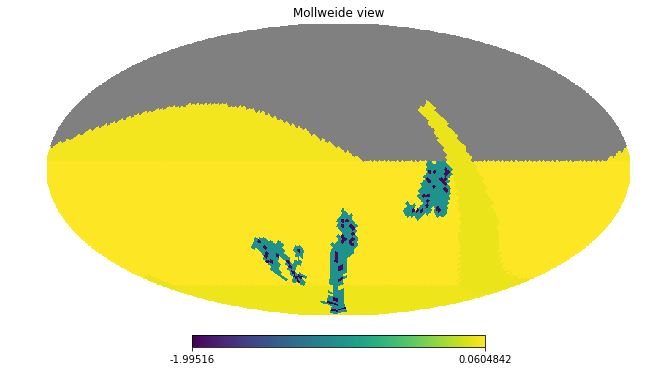

In [13]:
hp.mollview(sim.driver.scheduler.survey_lists[0][2].basis_functions[2]())